# Setup Your Analysis Environment

1) Choose a directory to house your project in: 
```
.../<project-directory>
```


2) Create and activate a fresh Python3 virtual environment there: 
```
$ cd .../<project-directory>
$ python -m virtualenv env #Package tested on Python 3.6.8
$ source env/bin/activate
```

3) Download the `cosmicfish` package from Git: 
```
$ git clone git@github.com:ndeporzio/cosmicfish.git
```

4) Install the `cosmicfish` package. Note that its dependencies will install automatically.
```
$ cd cosmicfish
$ pip install . 
```

5) Launch Jupyter and open `tutorial.ipynb` notebook using Jupyter browser
```
$ jupyter notebook
```

6) Create a data folder where the analysis can store spectrum data. This can be anywhere you'd like - you'll specify the path below. 
```
$ mkdir <project-directory>/data
```

7) Install and build CLASS (if you don't already have a build). Note the `cosmicfish` package includes a method for downloading and installing CLASS for you. 
```
$ python 
>>> import cosmicfish
>>> cosmicfish.install_class('<project-directory>/class')
>>> exit()
```

# Setup Fiducial Cosmology

Import the analysis package.

In [ ]:
import cosmicfish as cf 

Import relevant python packages... 

In [ ]:
#Import relevant packages
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

Other setup steps... 

In [ ]:
#Instruct pyplot to use seaborn 
sns.set()

Specify the paths from the setup of your analysis environment above.  

In [ ]:
#Set project, data, CLASS directories 
projectdir = cf.correct_path("~/Desktop/test/")
datastore = cf.correct_path("/Volumes/SSD01/data/")
classpath = os.path.join(projectdir, "class")

Specify the values of your fiducial cosmology and other physical constants.

In [ ]:
#Setup fiducial cosmology, note change to N_ncdm... 
fid = {"A_s" : 2.2321e-9, 
        "n_s" : 0.96659,
        "omega_b" : 0.02226,
        "omega_cdm" : 0.11271,
        "tau_reio" : 0.059888,
        "h" : 0.70148,
        "N_ncdm" : 1, #Note the change! 
        "m_ncdm" : 0.1, #Comment out for N_ncdm=0
        "T_ncdm" : 1.4/2.726, #Comment out for N_ncdm=0
        "z_pk" : 0.7, 
        "T_cmb" : 2.726} #Not necessary, but helps neatness later on

A_s = fid['A_s']
n_s = fid['n_s']
omega_b = fid['omega_b']
omega_cdm = fid['omega_cdm']
tau_reio = fid['tau_reio']
h = fid['h']
z_pk = fid['z_pk']
T_cmb = fid['T_cmb'] #Units of K

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * h #Units of m/s/Mpc
kp = 0.05 * h #Units of 1/Mpc

Specify the parameter values you'd like to use to compute the forecast...

In [ ]:
#Setup redshift bins, fiducial relica masses to sample
z_table = np.arange(1.0, 1.1, 0.1)
m_chi = 0.1

# Convergence Analysis

Before running the forecast, we want to ensure our cosmological parameters are well converged about the points we are interested in using to calculate Fisher matrices. To do so, we can use the `relic_convergence_analysis` class of `cosmicfish`. 

We pass to `relic_convergence_analysis` some fiducial cosmology, and then it will vary the parameters of that fiducial cosmology to values specified by the user and compute the corresponding power spectrum derivatives. You can choose to pass specific values of the fiducial cosmology, or choose to vary relative to the fiducial cosmology. 

First, specify the points in parameter space you'd like to sample: 

In [ ]:
T_chi_table = np.arange(1.8, 2.1, 0.02) / T_cmb #Units of T_cmb. We specify absolute values for the T_chi parameter.
nonT_relvary = np.arange(1.01, 1.11, 0.01) #We specify values relative to the fiducial cosmology for other parameters.

Then, we generate instances of the `relic_convergence_analysis` class. It will search for pre-existing datasets for the specified points in parameter space in the datastore directory - otherwise, it will generate the dataset and place it in datastore. 

In [ ]:
conv1 = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore); 
conv2 = cf.relic_convergence_analysis(fid, 'omega_b', 'rel', nonT_relvary, z_table, None, classpath, datastore);
conv3 = cf.relic_convergence_analysis(fid, 'omega_cdm', 'rel', nonT_relvary, z_table, None, classpath, datastore);
conv4 = cf.relic_convergence_analysis(fid, 'tau_reio', 'rel', nonT_relvary, z_table, None, classpath, datastore);
conv5 = cf.relic_convergence_analysis(fid, 'h', 'rel', nonT_relvary, z_table, None, classpath, datastore);

At this point, all the useful information generated in the convergence analysis is accessed through the methods of the `relic_convergence_analysis` objects. We use those methods to plot the results of the analysis...

### Convergence Power Spectra

In [ ]:
conv1.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv2.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv3.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv4.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv5.plot_ps(z_index=0, xscale='linear', plotdata=True)

### Convergence Derivatives of Power Spectra

In [ ]:
conv1.plot_dps(z_index=0, xscale='linear')
conv2.plot_dps(z_index=0, xscale='linear')
conv3.plot_dps(z_index=0, xscale='linear')
conv4.plot_dps(z_index=0, xscale='linear')
conv5.plot_dps(z_index=0, xscale='linear')

### Convergence Difference of Derivatives of Power Spectra

In [ ]:
conv1.plot_delta_dps(z_index=0, xscale='linear')
conv2.plot_delta_dps(z_index=0, xscale='linear')
conv3.plot_delta_dps(z_index=0, xscale='linear')
conv4.plot_delta_dps(z_index=0, xscale='linear')
conv5.plot_delta_dps(z_index=0, xscale='linear')

### Repeat for Other $m_\chi$

We can easily repeate the analysis above for other choice of $m_\chi$. 

In [ ]:
conv1a = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., -1.0), classpath, datastore)
conv1b = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., -0.8), classpath, datastore)
conv1c = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., -0.6), classpath, datastore)
conv1d = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., -0.4), classpath, datastore)
conv1e = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., -0.2), classpath, datastore)
conv1f = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., 0.0), classpath, datastore)
conv1g = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., 0.2), classpath, datastore)
conv1h = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., 0.4), classpath, datastore)
conv1i = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., 0.6), classpath, datastore)
conv1j = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., 0.8), classpath, datastore)
conv1k = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, np.power(10., 1.0), classpath, datastore)

conv1a.plot_dps(z_index=1, xscale='linear')
conv1b.plot_dps(z_index=1, xscale='linear')
conv1c.plot_dps(z_index=0, xscale='linear')
conv1d.plot_dps(z_index=0, xscale='linear')
conv1e.plot_dps(z_index=0, xscale='linear')
conv1f.plot_dps(z_index=0, xscale='linear')
conv1g.plot_dps(z_index=0, xscale='linear')
conv1h.plot_dps(z_index=0, xscale='linear')
conv1i.plot_dps(z_index=0, xscale='linear')
conv1j.plot_dps(z_index=0, xscale='linear')
conv1k.plot_dps(z_index=0, xscale='linear')

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.
# Analysis - No Commentary

In [ ]:
#Import relevant packages
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cosmicfish as cf


#Instruct pyplot to use seaborn 
sns.set()

#Set project, data, CLASS directories 
projectdir = cf.correct_path("~/Desktop/test/")
datastore = cf.correct_path("~/Desktop/test/data/")
classpath = os.path.join(projectdir, "class")

#Setup fiducial cosmology, note change to N_ncdm... 
fid = {"A_s" : 2.2321e-9, 
        "n_s" : 0.96659,
        "omega_b" : 0.02226,
        "omega_cdm" : 0.11271,
        "tau_reio" : 0.059888,
        "h" : 0.70148,
        "N_ncdm" : 1, #Note the change! 
        "z_pk" : 0.7, 
        "T_cmb" : 2.726,
        "T_ncdm" : 1.5/2.726} #Not necessary, but helps neatness later on

A_s = fid['A_s']
n_s = fid['n_s']
omega_b = fid['omega_b']
omega_cdm = fid['omega_cdm']
tau_reio = fid['tau_reio']
h = fid['h']
z_pk = fid['z_pk']
T_cmb = fid['T_cmb'] #Units of K

c = 2.9979e8 #Units of m/s
H = 1000. * 100. * h #Units of m/s/Mpc
kp = 0.05 * h #Units of 1/Mpc


#Setup redshift bins, fiducial relica masses, relic temps to sample
#z_table = np.arange(1.4, 1.5, 0.1)
z_table = np.array([1.4, 1.5])
m_chi = 1.0
#T_chi_table = np.arange(1.0, 2.0, 0.1) / T_cmb #Units of T_cmb
T_chi_table = np.array([1.5]) / T_cmb #Units of T_cmb
#nonT_relvary = np.arange(1.0, 1.11, 0.01)
nonT_relvary = np.array([1.0])

In [ ]:
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 1.0)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.9)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.8)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.7)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.6)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.5)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.4)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.3)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.2)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.1)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., 0.0)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.1)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.2)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.3)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.4)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.5)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.6)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.7)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.8)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -0.9)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)

In [ ]:
datastore = cf.correct_path("~/Desktop/test/data/")
conv1 = cf.relic_convergence_analysis(dict(fid, **{'m_ncdm' : np.power(10., -1.0)}), 'n_s', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.03)

In [ ]:
conv1 = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.01, fsky=0.3394)
#conv2 = cf.relic_convergence_analysis(fid, 'omega_b', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.01);
#conv3 = cf.relic_convergence_analysis(fid, 'omega_cdm', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.01);
#conv4 = cf.relic_convergence_analysis(fid, 'tau_reio', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.01);
#conv5 = cf.relic_convergence_analysis(fid, 'h', 'rel', nonT_relvary, z_table, None, classpath, datastore, dstep=0.01); 

In [ ]:
conv1.plot_ps(z_index=0, xscale='linear', plotdata=True)

In [ ]:
print(conv1.spectra[0][0].class_pk[34:60]*np.power(0.70148, -3))

In [ ]:
conv1.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv2.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv3.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv4.plot_ps(z_index=0, xscale='linear', plotdata=True)
conv5.plot_ps(z_index=0, xscale='linear', plotdata=True)

print('..................................................................................')
print('..................................................................................')
print('..................................................................................')

conv1.plot_dps(z_index=0, xscale='linear')
conv2.plot_dps(z_index=0, xscale='linear')
conv3.plot_dps(z_index=0, xscale='linear')
conv4.plot_dps(z_index=0, xscale='linear')
conv5.plot_dps(z_index=0, xscale='linear')

print('..................................................................................')
print('..................................................................................')
print('..................................................................................')

conv1.plot_delta_dps(z_index=0, xscale='linear')
conv2.plot_delta_dps(z_index=0, xscale='linear')
conv3.plot_delta_dps(z_index=0, xscale='linear')
conv4.plot_delta_dps(z_index=0, xscale='linear')
conv5.plot_delta_dps(z_index=0, xscale='linear')

In [ ]:
#Setup redshift bins, fiducial relica masses, relic temps to sample
z_table = np.arange(1.0, 1.1, 0.1)
m_chi = 0.1
T_chi_table = np.arange(1.5, 1.6, 0.1) / T_cmb #Units of T_cmb

conv1a = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.01)
conv1b = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.02)
conv1c = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.03)
conv1d = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.04)
conv1e = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.05)
conv1f = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.06)
conv1g = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.07)
conv1h = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.08)
conv1i = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.09)
conv1j = cf.relic_convergence_analysis(fid, 'T_ncdm', 'abs', T_chi_table, z_table, m_chi, classpath, datastore, dstep=0.10)

In [ ]:
sns.set()
sns.set_palette("Blues_d", n_colors=10)
plt.figure(figsize=(15, 7.5))
ax1 = plt.subplot(1, 2, 1)

ax1.plot(conv1a.spectra[0][0].k_table, conv1a.dps[0][0], label='step=1%')
ax1.plot(conv1b.spectra[0][0].k_table, conv1b.dps[0][0], label='step=2%')
ax1.plot(conv1c.spectra[0][0].k_table, conv1c.dps[0][0], label='step=3%')
ax1.plot(conv1d.spectra[0][0].k_table, conv1d.dps[0][0], label='step=4%')
ax1.plot(conv1e.spectra[0][0].k_table, conv1e.dps[0][0], label='step=5%')
ax1.plot(conv1f.spectra[0][0].k_table, conv1f.dps[0][0], label='step=6%')
ax1.plot(conv1g.spectra[0][0].k_table, conv1g.dps[0][0], label='step=7%')
ax1.plot(conv1h.spectra[0][0].k_table, conv1h.dps[0][0], label='step=8%')
ax1.plot(conv1i.spectra[0][0].k_table, conv1i.dps[0][0], label='step=9%')
ax1.plot(conv1j.spectra[0][0].k_table, conv1j.dps[0][0], label='step=10%')

ax1.set_title(r'$\partial P_g / \partial$ T_ncdm for z=1.0, m_ncdm=0.1 [eV]')
ax1.set_xlabel(r'k [Mpc$^{-1}$]')
ax1.set_ylabel(r'[Mpc$^3$ / (units of T_ncdm)]')
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(conv1a.spectra[0][0].k_table, conv1a.dlogps[0][0], label='step=1%')
ax2.plot(conv1b.spectra[0][0].k_table, conv1b.dlogps[0][0], label='step=2%')
ax2.plot(conv1c.spectra[0][0].k_table, conv1c.dlogps[0][0], label='step=3%')
ax2.plot(conv1d.spectra[0][0].k_table, conv1d.dlogps[0][0], label='step=4%')
ax2.plot(conv1e.spectra[0][0].k_table, conv1e.dlogps[0][0], label='step=5%')
ax2.plot(conv1f.spectra[0][0].k_table, conv1f.dlogps[0][0], label='step=6%')
ax2.plot(conv1g.spectra[0][0].k_table, conv1g.dlogps[0][0], label='step=7%')
ax2.plot(conv1h.spectra[0][0].k_table, conv1h.dlogps[0][0], label='step=8%')
ax2.plot(conv1i.spectra[0][0].k_table, conv1i.dlogps[0][0], label='step=9%')
ax2.plot(conv1j.spectra[0][0].k_table, conv1j.dlogps[0][0], label='step=10%')
ax2.set_title(r'$\partial log(P_g) / \partial$ T_ncdm for z=1.0, m_ncdm=0.1 [eV]')
ax2.set_xlabel(r'k [Mpc$^{-1}$]')
ax2.set_ylabel(r'[Mpc$^3$ / (units of T_ncdm)]')
ax2.legend()
        
plt.show()


domega_chi_dT_chi = (3* np.power(1.5, 2.) * 0.1) / (np.power(1.95, 3.) * 94.)

sns.set()
sns.set_palette("Blues_d", n_colors=10)
plt.figure(figsize=(15, 7.5))
ax1 = plt.subplot(1, 2, 1)

ax1.plot(conv1a.spectra[0][0].k_table, conv1a.dps[0][0]/domega_chi_dT_chi, label='step=1%')
ax1.plot(conv1b.spectra[0][0].k_table, conv1b.dps[0][0]/domega_chi_dT_chi, label='step=2%')
ax1.plot(conv1c.spectra[0][0].k_table, conv1c.dps[0][0]/domega_chi_dT_chi, label='step=3%')
ax1.plot(conv1d.spectra[0][0].k_table, conv1d.dps[0][0]/domega_chi_dT_chi, label='step=4%')
ax1.plot(conv1e.spectra[0][0].k_table, conv1e.dps[0][0]/domega_chi_dT_chi, label='step=5%')
ax1.plot(conv1f.spectra[0][0].k_table, conv1f.dps[0][0]/domega_chi_dT_chi, label='step=6%')
ax1.plot(conv1g.spectra[0][0].k_table, conv1g.dps[0][0]/domega_chi_dT_chi, label='step=7%')
ax1.plot(conv1h.spectra[0][0].k_table, conv1h.dps[0][0]/domega_chi_dT_chi, label='step=8%')
ax1.plot(conv1i.spectra[0][0].k_table, conv1i.dps[0][0]/domega_chi_dT_chi, label='step=9%')
ax1.plot(conv1j.spectra[0][0].k_table, conv1j.dps[0][0]/domega_chi_dT_chi, label='step=10%')

ax1.set_title(r'$\partial P_g / \partial$ omega_ncdm for z=1.0, m_ncdm=0.1 [eV]')
ax1.set_xlabel(r'k [Mpc$^{-1}$]')
ax1.set_ylabel(r'[Mpc$^3$ / (units of omega_ncdm)]')
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(conv1a.spectra[0][0].k_table, conv1a.dlogps[0][0]/domega_chi_dT_chi, label='step=1%')
ax2.plot(conv1b.spectra[0][0].k_table, conv1b.dlogps[0][0]/domega_chi_dT_chi, label='step=2%')
ax2.plot(conv1c.spectra[0][0].k_table, conv1c.dlogps[0][0]/domega_chi_dT_chi, label='step=3%')
ax2.plot(conv1d.spectra[0][0].k_table, conv1d.dlogps[0][0]/domega_chi_dT_chi, label='step=4%')
ax2.plot(conv1e.spectra[0][0].k_table, conv1e.dlogps[0][0]/domega_chi_dT_chi, label='step=5%')
ax2.plot(conv1f.spectra[0][0].k_table, conv1f.dlogps[0][0]/domega_chi_dT_chi, label='step=6%')
ax2.plot(conv1g.spectra[0][0].k_table, conv1g.dlogps[0][0]/domega_chi_dT_chi, label='step=7%')
ax2.plot(conv1h.spectra[0][0].k_table, conv1h.dlogps[0][0]/domega_chi_dT_chi, label='step=8%')
ax2.plot(conv1i.spectra[0][0].k_table, conv1i.dlogps[0][0]/domega_chi_dT_chi, label='step=9%')
ax2.plot(conv1j.spectra[0][0].k_table, conv1j.dlogps[0][0]/domega_chi_dT_chi, label='step=10%')
ax2.set_title(r'$\partial log(P_g) / \partial$ omega_ncdm for z=1.0, m_ncdm=0.1 [eV]')
ax2.set_xlabel(r'k [Mpc$^{-1}$]')
ax2.set_ylabel(r'[Mpc$^3$ / (units of omega_ncdm)]')
ax2.legend()
        
plt.show()

sns.set()
sns.set_palette("Blues_d", n_colors=10)
plt.figure(figsize=(15, 7.5))
ax1 = plt.subplot(1, 2, 1)

ax1.plot(conv1a.spectra[0][0].k_table, conv1a.dps[0][0]/domega_chi_dT_chi - conv1b.dps[0][0]/domega_chi_dT_chi, label='step=1%')
ax1.plot(conv1b.spectra[0][0].k_table, conv1b.dps[0][0]/domega_chi_dT_chi - conv1c.dps[0][0]/domega_chi_dT_chi, label='step=2%')
ax1.plot(conv1c.spectra[0][0].k_table, conv1c.dps[0][0]/domega_chi_dT_chi - conv1d.dps[0][0]/domega_chi_dT_chi, label='step=3%')
ax1.plot(conv1d.spectra[0][0].k_table, conv1d.dps[0][0]/domega_chi_dT_chi - conv1e.dps[0][0]/domega_chi_dT_chi, label='step=4%')
ax1.plot(conv1e.spectra[0][0].k_table, conv1e.dps[0][0]/domega_chi_dT_chi - conv1f.dps[0][0]/domega_chi_dT_chi, label='step=5%')
ax1.plot(conv1f.spectra[0][0].k_table, conv1f.dps[0][0]/domega_chi_dT_chi - conv1g.dps[0][0]/domega_chi_dT_chi, label='step=6%')
ax1.plot(conv1g.spectra[0][0].k_table, conv1g.dps[0][0]/domega_chi_dT_chi - conv1h.dps[0][0]/domega_chi_dT_chi, label='step=7%')
ax1.plot(conv1h.spectra[0][0].k_table, conv1h.dps[0][0]/domega_chi_dT_chi - conv1i.dps[0][0]/domega_chi_dT_chi, label='step=8%')

ax1.set_title(r'$\Delta(\partial P_g / \partial$ omega_ncdm) for z=1.0, m_ncdm=0.1 [eV]')
ax1.set_xlabel(r'k [Mpc$^{-1}$]')
ax1.set_ylabel(r'[Mpc$^3$ / (units of omega_ncdm)]')
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(conv1a.spectra[0][0].k_table, conv1a.dlogps[0][0]/domega_chi_dT_chi - conv1b.dlogps[0][0]/domega_chi_dT_chi, label='step=1%')
ax2.plot(conv1b.spectra[0][0].k_table, conv1b.dlogps[0][0]/domega_chi_dT_chi - conv1c.dlogps[0][0]/domega_chi_dT_chi, label='step=2%')
ax2.plot(conv1c.spectra[0][0].k_table, conv1c.dlogps[0][0]/domega_chi_dT_chi - conv1d.dlogps[0][0]/domega_chi_dT_chi, label='step=3%')
ax2.plot(conv1d.spectra[0][0].k_table, conv1d.dlogps[0][0]/domega_chi_dT_chi - conv1e.dlogps[0][0]/domega_chi_dT_chi, label='step=4%')
ax2.plot(conv1e.spectra[0][0].k_table, conv1e.dlogps[0][0]/domega_chi_dT_chi - conv1f.dlogps[0][0]/domega_chi_dT_chi, label='step=5%')
ax2.plot(conv1f.spectra[0][0].k_table, conv1f.dlogps[0][0]/domega_chi_dT_chi - conv1g.dlogps[0][0]/domega_chi_dT_chi, label='step=6%')
ax2.plot(conv1g.spectra[0][0].k_table, conv1g.dlogps[0][0]/domega_chi_dT_chi - conv1h.dlogps[0][0]/domega_chi_dT_chi, label='step=7%')
ax2.plot(conv1h.spectra[0][0].k_table, conv1h.dlogps[0][0]/domega_chi_dT_chi - conv1i.dlogps[0][0]/domega_chi_dT_chi, label='step=8%')
ax2.plot(conv1i.spectra[0][0].k_table, conv1i.dlogps[0][0]/domega_chi_dT_chi - conv1j.dlogps[0][0]/domega_chi_dT_chi, label='step=9%')
ax2.set_title(r'$\Delta(\partial log(P_g) / \partial$ omega_ncdm) for z=1.0, m_ncdm=0.1 [eV]')
ax2.set_xlabel(r'k [Mpc$^{-1}$]')
ax2.set_ylabel(r'[Mpc$^3$ / (units of omega_ncdm)]')
ax2.legend()
        
plt.show()




.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [1]:
#Import relevant packages
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cosmicfish as cf


#Instruct pyplot to use seaborn 
sns.set()

#Set project, data, CLASS directories 
projectdir = cf.correct_path("~/Desktop/test/")
datastore = cf.correct_path("~/Desktop/test/data/")
#datastore = cf.correct_path("/Volumes/SSD01/data/")
classpath = os.path.join(projectdir, "class")

#Setup fiducial cosmology, note change to N_ncdm... 
fid = {"A_s" : 2.2321e-9, 
       "n_s" : 0.96659,
       "omega_b" : 0.02226,
       "omega_cdm" : 0.11271,
       "tau_reio" : 0.059888,
       "h" : 0.70148,
       "z_pk" : 1.4, 
       "T_cmb" : 2.726,
       "N_ncdm" : 3., 
       #"T_ncdm" : 1.5 / 2.726, 
       "m_ncdm" : 0.02} 


c = 2.9979e8 #Units of m/s
H = 1000. * 100. * fid['h'] #Units of m/s/Mpc
kp = 0.05 * fid['h'] #Units of 1/Mpc\
skycover = 14000. #Sky coverage of survey in degrees^2


#Setup redshift bins, fiducial relica masses, relic temps to sample
z_table = np.arange(0.65, 1.85, 0.1)
dNdz = np.array([309., 2269., 1923., 2094., 1441., 1353., 1337., 523., 466., 329., 126., 0., 0.])
dstep = 0.03 #Vary each parameter by +-3% to calculate derivatives about fiducial 
mu_step = 0.05 #For calculating numerical integral wrt mu between -1 and 1 

In [2]:
lightrelic = cf.relic_forecast(fid, z_table, dNdz, dstep, classpath, datastore, 'neutrino', fcoverage_deg=skycover)

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486015.1305990.718381
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485838.3959120.689332
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486016.0242220.662280
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485839.345810.403886
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485840.3611610.574408
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486016.9323070.784664
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485841.2705530.507684
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486017.8354220.708506
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485842.17174820.485579
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486018.7271120.415512
Dataset already exists at: /Users/nicholasdeporzio

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485919.76778390.301739
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485920.85245320.011324
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485921.89381980.587813
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485923.0661080.110073
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485924.1521630.338620
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485925.6294580.080946
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485927.0465960.351111
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485928.2613270.263647
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485929.3974330.529388
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563485930.5727710.215719
Dataset already exists at: /Users/nicholasdepor

Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486011.4908640.519574
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486012.37975720.127666
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486013.3022060.577247
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486014.21271920.051577
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486015.1305990.718381
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486016.0242220.662280
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486016.9323070.784664
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486017.8354220.708506
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486018.7271120.415512
Dataset already exists at: /Users/nicholasdeporzio/Desktop/test/data/1563486019.6349240.076889
Dataset already exists at: /Users/nicholasdeporz

In [3]:
lightrelic.print_v_table()

For z = 0.65 
	V = 2.926862 [h^-3 Gpc^3] 
	nbar = 147803.349863 [h^3 Gpc^-3] 
	nbar = 5.101879e-05 [Mpc^-3] 
	nbar/deg^2 = 1.055738e+01 [h^3 Gpc^-3 deg^-2] 
	nbar/deg^2 = 3.644199e-09 [Mpc^-3 deg^-2] 
	D = 0.727178 
	b_ELG = 1.155150 
	
For z = 0.75 
	V = 3.464387 [h^-3 Gpc^3] 
	nbar = 916929.919954 [h^3 Gpc^-3] 
	nbar = 3.165061e-04 [Mpc^-3] 
	nbar/deg^2 = 6.549499e+01 [h^3 Gpc^-3 deg^-2] 
	nbar/deg^2 = 2.260758e-08 [Mpc^-3 deg^-2] 
	D = 0.694241 
	b_ELG = 1.209955 
	
For z = 0.85 
	V = 3.815583 [h^-3 Gpc^3] 
	nbar = 705580.340493 [h^3 Gpc^-3] 
	nbar = 2.435524e-04 [Mpc^-3] 
	nbar/deg^2 = 5.039860e+01 [h^3 Gpc^-3 deg^-2] 
	nbar/deg^2 = 1.739660e-08 [Mpc^-3 deg^-2] 
	D = 0.663596 
	b_ELG = 1.265831 
	
For z = 0.95 
	V = 4.340863 [h^-3 Gpc^3] 
	nbar = 675349.555760 [h^3 Gpc^-3] 
	nbar = 2.331173e-04 [Mpc^-3] 
	nbar/deg^2 = 4.823925e+01 [h^3 Gpc^-3 deg^-2] 
	nbar/deg^2 = 1.665124e-08 [Mpc^-3 deg^-2] 
	D = 0.635083 
	b_ELG = 1.322661 
	
For z = 1.05 
	V = 4.747139 [h^-3 Gpc^3] 
	nbar = 42

In [4]:
lightrelic.gen_fisher(mu_step)

Fisher element ( 0 ,  0 ) calculated...
Fisher element ( 0 ,  1 ) calculated...
Fisher element ( 0 ,  2 ) calculated...
Fisher element ( 0 ,  3 ) calculated...
Fisher element ( 0 ,  4 ) calculated...
Fisher element ( 0 ,  5 ) calculated...
Fisher element ( 0 ,  6 ) calculated...
Fisher element ( 1 ,  0 ) calculated...
Fisher element ( 1 ,  1 ) calculated...
Fisher element ( 1 ,  2 ) calculated...
Fisher element ( 1 ,  3 ) calculated...
Fisher element ( 1 ,  4 ) calculated...
Fisher element ( 1 ,  5 ) calculated...
Fisher element ( 1 ,  6 ) calculated...
Fisher element ( 2 ,  0 ) calculated...
Fisher element ( 2 ,  1 ) calculated...
Fisher element ( 2 ,  2 ) calculated...
Fisher element ( 2 ,  3 ) calculated...
Fisher element ( 2 ,  4 ) calculated...
Fisher element ( 2 ,  5 ) calculated...
Fisher element ( 2 ,  6 ) calculated...
Fisher element ( 3 ,  0 ) calculated...
Fisher element ( 3 ,  1 ) calculated...
Fisher element ( 3 ,  2 ) calculated...
Fisher element ( 3 ,  3 ) calculated...


In [5]:
lightrelic.print_P_table()

For z = 0.65,	 P(0.2h, 0) = 2774.84

For z = 0.75,	 P(0.2h, 0) = 2529.18

For z = 0.85,	 P(0.2h, 0) = 2309.38

For z = 0.95,	 P(0.2h, 0) = 2115.19

For z = 1.05,	 P(0.2h, 0) = 1942.21

For z = 1.15,	 P(0.2h, 0) = 1787.88

For z = 1.25,	 P(0.2h, 0) = 1649.92

For z = 1.35,	 P(0.2h, 0) = 1527.17

For z = 1.45,	 P(0.2h, 0) = 1416.09

For z = 1.55,	 P(0.2h, 0) = 1315.35

For z = 1.65,	 P(0.2h, 0) = 1225.82

For z = 1.75,	 P(0.2h, 0) = 1144.16

For z = 1.85,	 P(0.2h, 0) = 1070.09



In [6]:
lssfisher = lightrelic.fisher
lssfisher = pd.DataFrame(lssfisher,  columns=['omega_b', 'omega_cdm', 'n_s', 'A_s', 'tau_reio', 'h', 'M_ncdm'])
lssfisher

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,M_ncdm
0,1.466252e+08,-1.911071e+08,-1.188342e+07,-5.166834e+15,2.027463e+04,-1.085311e+08,1.064359e+07
1,-1.911071e+08,3.335634e+08,2.098104e+07,8.175532e+15,-3.210291e+04,1.826309e+08,-1.661030e+07
2,-1.188342e+07,2.098104e+07,1.445187e+06,4.941248e+14,-1.943685e+03,1.105564e+07,-1.003357e+06
3,-5.166834e+15,8.175532e+15,4.941248e+14,2.123856e+23,-8.334050e+11,4.576384e+15,-4.345517e+14
4,2.027463e+04,-3.210291e+04,-1.943685e+03,-8.334050e+11,3.288906e+00,-1.797604e+04,1.705564e+03
5,-1.085311e+08,1.826309e+08,1.105564e+07,4.576384e+15,-1.797604e+04,1.035301e+08,-9.305991e+06
6,1.064359e+07,-1.661030e+07,-1.003357e+06,-4.345517e+14,1.705564e+03,-9.305991e+06,8.906593e+05


In [7]:
lssfisher.iloc[:,6] *= 3.
lssfisher.iloc[6,:] *= 3.
lssfisher = lssfisher.rename(index=str, columns={"M_ncdm": "m_ncdm"})
lssfisher

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,m_ncdm
0,1.466252e+08,-1.911071e+08,-1.188342e+07,-5.166834e+15,2.027463e+04,-1.085311e+08,3.193078e+07
1,-1.911071e+08,3.335634e+08,2.098104e+07,8.175532e+15,-3.210291e+04,1.826309e+08,-4.983089e+07
2,-1.188342e+07,2.098104e+07,1.445187e+06,4.941248e+14,-1.943685e+03,1.105564e+07,-3.010071e+06
3,-5.166834e+15,8.175532e+15,4.941248e+14,2.123856e+23,-8.334050e+11,4.576384e+15,-1.303655e+15
4,2.027463e+04,-3.210291e+04,-1.943685e+03,-8.334050e+11,3.288906e+00,-1.797604e+04,5.116691e+03
5,-1.085311e+08,1.826309e+08,1.105564e+07,4.576384e+15,-1.797604e+04,1.035301e+08,-2.791797e+07
6,3.193078e+07,-4.983089e+07,-3.010071e+06,-1.303655e+15,5.116691e+03,-2.791797e+07,8.015934e+06


In [8]:
lsscovariance = np.linalg.inv(lssfisher)
lsscovariance = pd.DataFrame(lsscovariance, columns=lssfisher.columns)
lsscovariance

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,m_ncdm
0,9.052056e-08,-1.690293e-07,9.446645e-07,6.801041e-15,1.061366e-04,8.312878e-08,2.712299e-07
1,-1.690293e-07,8.693303e-07,-4.587755e-06,-5.619444e-14,-2.042754e-04,-4.484909e-07,-6.215948e-06
2,9.446645e-07,-4.587755e-06,2.824724e-05,2.630673e-13,2.271259e-03,2.198696e-06,2.731575e-05
3,6.801041e-15,-5.619444e-14,2.630673e-13,1.059333e-20,1.265094e-10,-3.209444e-15,1.353256e-12
4,1.061366e-04,-2.042754e-04,2.271259e-03,1.265094e-10,5.555831e+01,6.923622e-04,-1.331752e-02
5,8.312878e-08,-4.484909e-07,2.198696e-06,-3.209444e-15,6.923622e-04,6.057891e-07,-1.147595e-06
6,2.712299e-07,-6.215948e-06,2.731575e-05,1.353256e-12,-1.331752e-02,-1.147595e-06,1.952483e-04


In [9]:
cmbfisher = pd.read_csv("~/Desktop/CMBS4_Fisher.dat", sep='\t', header=0)
pd.DataFrame(cmbfisher)

,omega_b,omega_cdm,n_s,A_s,tau_reio,H_0,M_ncdm
0,5.671444e+09,-8.256715e+08,1.262203e+08,4.427530e+16,-1.865828e+08,-2.423918e+06,-2.292377e+07
1,-8.256715e+08,2.721312e+08,-1.455229e+07,-5.958876e+15,2.938383e+07,6.313072e+05,5.264818e+06
2,1.262203e+08,-1.455229e+07,4.507586e+06,1.756750e+15,-7.224198e+06,-4.846603e+04,-5.002335e+05
3,4.427530e+16,-5.958876e+15,1.756750e+15,8.574492e+23,-3.462911e+15,-1.936594e+13,-2.140669e+14
4,-1.865828e+08,2.938383e+07,-7.224198e+06,-3.462911e+15,1.464674e+07,7.724960e+04,7.583209e+05
5,-2.423918e+06,6.313072e+05,-4.846603e+04,-1.936594e+13,7.724960e+04,1.847058e+03,1.797380e+04
6,-2.292377e+07,5.264818e+06,-5.002335e+05,-2.140669e+14,7.583209e+05,1.797380e+04,1.906145e+05


In [10]:
cmbfisher.iloc[:,5] *= 100.
cmbfisher.iloc[5,:] *= 100.
cmbfisher.iloc[:,6] *= 3.
cmbfisher.iloc[6,:] *= 3.
cmbfisher = cmbfisher.rename(index=str, columns={"H_0": "h", "M_ncdm": "m_ncdm"})
cmbfisher

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,m_ncdm
0,5.671444e+09,-8.256715e+08,1.262203e+08,4.427530e+16,-1.865828e+08,-2.423918e+08,-6.877131e+07
1,-8.256715e+08,2.721312e+08,-1.455229e+07,-5.958876e+15,2.938383e+07,6.313072e+07,1.579445e+07
2,1.262203e+08,-1.455229e+07,4.507586e+06,1.756750e+15,-7.224198e+06,-4.846603e+06,-1.500700e+06
3,4.427530e+16,-5.958876e+15,1.756750e+15,8.574492e+23,-3.462911e+15,-1.936594e+15,-6.422007e+14
4,-1.865828e+08,2.938383e+07,-7.224198e+06,-3.462911e+15,1.464674e+07,7.724960e+06,2.274963e+06
5,-2.423918e+08,6.313072e+07,-4.846603e+06,-1.936594e+15,7.724960e+06,1.847058e+07,5.392139e+06
6,-6.877131e+07,1.579445e+07,-1.500700e+06,-6.422007e+14,2.274963e+06,5.392139e+06,1.715530e+06


In [11]:
cmbcovariance = pd.DataFrame(np.linalg.inv(cmbfisher), columns=cmbfisher.columns)
cmbcovariance

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,m_ncdm
0,9.698656e-10,-3.706216e-09,-2.040187e-08,-1.089038e-16,-2.612849e-08,6.352855e-08,-1.506427e-07
1,-3.706216e-09,5.915852e-07,-1.271759e-06,5.626026e-16,-6.489262e-07,-5.198475e-06,1.070300e-05
2,-2.040187e-08,-1.271759e-06,4.795502e-06,-2.986842e-17,2.392210e-06,1.042241e-05,-2.085664e-05
3,-1.089038e-16,5.626026e-16,-2.986842e-17,1.066603e-21,2.459298e-13,-1.570631e-13,5.572492e-13
4,-2.612849e-08,-6.489262e-07,2.392210e-06,2.459298e-13,5.810323e-05,-2.965731e-05,1.152486e-04
5,6.352855e-08,-5.198475e-06,1.042241e-05,-1.570631e-13,-2.965731e-05,6.833625e-05,-1.747322e-04
6,-1.506427e-07,1.070300e-05,-2.085664e-05,5.572492e-13,1.152486e-04,-1.747322e-04,4.827385e-04


In [12]:
fullfisher = lssfisher + cmbfisher
fullfisher

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,m_ncdm
0,5.818069e+09,-1.016779e+09,1.143369e+08,3.910847e+16,-1.865626e+08,-3.509229e+08,-3.684053e+07
1,-1.016779e+09,6.056947e+08,6.428751e+06,2.216655e+15,2.935173e+07,2.457616e+08,-3.403644e+07
2,1.143369e+08,6.428751e+06,5.952773e+06,2.250874e+15,-7.226141e+06,6.209042e+06,-4.510771e+06
3,3.910847e+16,2.216655e+15,2.250874e+15,1.069835e+24,-3.463744e+15,2.639791e+15,-1.945856e+15
4,-1.865626e+08,2.935173e+07,-7.226141e+06,-3.463744e+15,1.464674e+07,7.706984e+06,2.280080e+06
5,-3.509229e+08,2.457616e+08,6.209042e+06,2.639791e+15,7.706984e+06,1.220007e+08,-2.252583e+07
6,-3.684053e+07,-3.403644e+07,-4.510771e+06,-1.945856e+15,2.280080e+06,-2.252583e+07,9.731464e+06


In [13]:
fullcovariance = pd.DataFrame(np.linalg.inv(fullfisher), columns=fullfisher.columns)
fullcovariance

,omega_b,omega_cdm,n_s,A_s,tau_reio,h,m_ncdm
0,7.833857e-10,2.158199e-09,-2.482994e-08,-3.913372e-17,-1.500113e-08,-2.740230e-11,-5.368822e-09
1,2.158199e-09,1.066522e-07,-3.441559e-07,-5.089324e-15,-1.355543e-06,-1.461572e-07,-8.166803e-07
2,-2.482994e-08,-3.441559e-07,2.431865e-06,1.447966e-14,4.392206e-06,3.849278e-07,2.586719e-06
3,-3.913372e-17,-5.089324e-15,1.447966e-14,2.876082e-22,7.449970e-14,6.625479e-15,4.415301e-14
4,-1.500113e-08,-1.355543e-06,4.392206e-06,7.449970e-14,1.965819e-05,1.746741e-06,1.157194e-05
5,-2.740230e-11,-1.461572e-07,3.849278e-07,6.625479e-15,1.746741e-06,2.389544e-07,1.135780e-06
6,-5.368822e-09,-8.166803e-07,2.586719e-06,4.415301e-14,1.157194e-05,1.135780e-06,7.171402e-06


In [14]:
print("Fully Marginalized Error on A_s: ", np.sqrt(fullcovariance.iloc[0,0]))
print("Fully Marginalized Error on n_s: ", np.sqrt(fullcovariance.iloc[1,1]))
print("Fully Marginalized Error on omega_b: ", np.sqrt(fullcovariance.iloc[2,2]))
print("Fully Marginalized Error on omega_cdm: ", np.sqrt(fullcovariance.iloc[3,3]))
print("Fully Marginalized Error on h: ", np.sqrt(fullcovariance.iloc[4,4]))
print("Fully Marginalized Error on tau_reio: ", np.sqrt(fullcovariance.iloc[5,5]))
print("Fully Marginalized Error on M_ncdm: ", np.sqrt(fullcovariance.iloc[6,6]))

Fully Marginalized Error on A_s:  2.7989028861950765e-05
Fully Marginalized Error on n_s:  0.00032657647245829544
Fully Marginalized Error on omega_b:  0.0015594439572820626
Fully Marginalized Error on omega_cdm:  1.6959014578447333e-11
Fully Marginalized Error on h:  0.004433755482983349
Fully Marginalized Error on tau_reio:  0.0004888296428182098
Fully Marginalized Error on M_ncdm:  0.0026779473866767075


In [15]:
pd.DataFrame(fullcovariance).to_csv("~/Desktop/inv_fullfisher.mat", sep="\t", index=False, header=['# omega_b', 'omega_cdm', 'n_s', 'A_s', 'tau_reio', 'h', 'm_0'])

In [16]:
pd.DataFrame(cmbcovariance).to_csv("~/Desktop/inv_cmbfisher.mat", sep="\t", index=False, header=['# omega_b', 'omega_cdm', 'n_s', 'A_s', 'tau_reio', 'h', 'm_0'])

In [17]:
pd.DataFrame(lsscovariance).to_csv("~/Desktop/inv_lssfisher.mat", sep="\t", index=False, header=['# omega_b', 'omega_cdm', 'n_s', 'A_s', 'tau_reio', 'h', 'm_0'])

In [18]:
print("Looking for k = ", 0.2 * fid['h'], " [Mpc^-1]")
print(lightrelic.k_table)
kidx = 69
muidx = 20

print(lightrelic.k_table[kidx])
print(np.arange(-1., 1., mu_step)[muidx])

for zidx, zval in enumerate(z_table): 
    print("For z = {0:.2f},\t P(0.2h, 0) = {1:.2f},\t nbar * P_(0.2h, 0) = {1:.2e}".format(zval, 
                                                                                         lightrelic.Pm[zidx][kidx][muidx],
                                                                                         lightrelic.Pm[zidx][kidx][muidx]*lightrelic.n_densities[zidx]))

Looking for k =  0.140296  [Mpc^-1]
[0.0014723  0.00347763 0.00548296 0.00748829 0.00949362 0.01149895
 0.01350428 0.01550961 0.01751494 0.01952027 0.02152561 0.02353094
 0.02553627 0.0275416  0.02954693 0.03155226 0.03355759 0.03556292
 0.03756825 0.03957358 0.04157891 0.04358424 0.04558957 0.0475949
 0.04960023 0.05160556 0.05361089 0.05561622 0.05762155 0.05962688
 0.06163221 0.06363754 0.06564287 0.0676482  0.06965353 0.07165886
 0.07366419 0.07566952 0.07767485 0.07968018 0.08168551 0.08369084
 0.08569617 0.0877015  0.08970683 0.09171216 0.0937175  0.09572283
 0.09772816 0.09973349 0.10173882 0.10374415 0.10574948 0.10775481
 0.10976014 0.11176547 0.1137708  0.11577613 0.11778146 0.11978679
 0.12179212 0.12379745 0.12580278 0.12780811 0.12981344 0.13181877
 0.1338241  0.13582943 0.13783476 0.13984009 0.14184542 0.14385075
 0.14585608 0.14786141 0.14986674 0.15187207 0.1538774  0.15588273
 0.15788806 0.15989339 0.16189872 0.16390405 0.16590939 0.16791472
 0.16992005 0.17192538 0.17

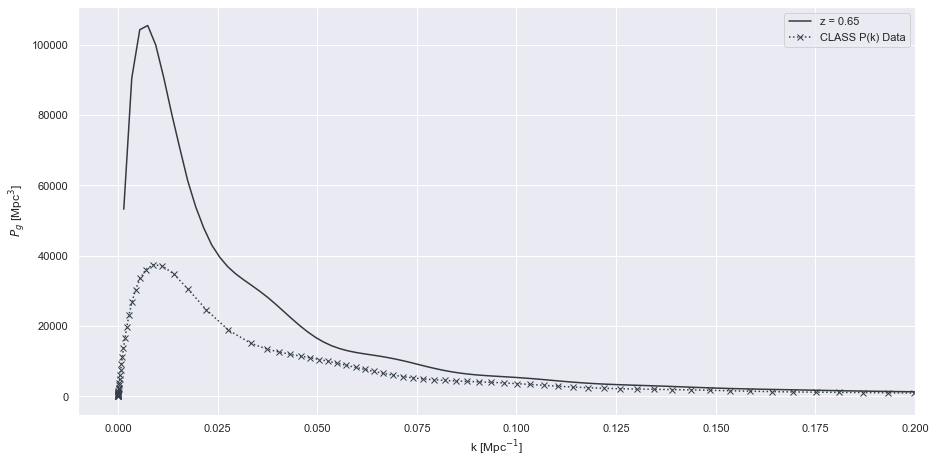

In [19]:
#For each z, plot inferred spectrum vs. CLASS data
sns.set()
sns.set_palette("Blues_d", n_colors=2*len(z_table)+1)
plt.figure(figsize=(15, 7.5))
for zidx, zval in enumerate(z_table[0:1]): 
    ps = lightrelic.spectra_mid[zidx]
    plt.plot(ps.k_table, ps.ps_table, label=("z = " + str(zval)))
    plt.plot(ps.class_pk['k (h/Mpc)']*0.70148,
             ps.class_pk['P (Mpc/h)^3']*np.power(0.70148, -3),
             label='CLASS P(k) Data',
             marker='x',
             linestyle=':')
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'$P_g$ [Mpc$^3$]')
plt.xlim(-0.01, 0.2)
plt.legend()
plt.show()
#Also plot difference between the two 